# Explore here

# Paso 1: Configuración inicial y Carga de Incendios

In [1]:
import sqlite3
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils import resample




- Conectamos a la base de datos y extraemos una muestra.
  - Conexión a la base de datos EFFIS

In [5]:

db_path = '../data/raw/effis_layer.db'
conexion = sqlite3.connect(db_path)
sql_query = 'SELECT * FROM "modis.ba.poly" LIMIT 50000' 

df = pd.read_sql_query(sql_query, conexion)

- Exploración de la base de datos de USA ---
-  Conectamos para ver los nombres de las tablas

In [6]:
conn = sqlite3.connect('../data/raw/FPA_FOD_20221014.sqlite')

cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tablas = cursor.fetchall()

print("Tablas encontradas en la base de datos:")
for tabla in tablas:
    print(tabla[0])

Tablas encontradas en la base de datos:
spatial_ref_sys
spatialite_history
sqlite_sequence
geometry_columns
views_geometry_columns
virts_geometry_columns
geometry_columns_statistics
views_geometry_columns_statistics
virts_geometry_columns_statistics
geometry_columns_field_infos
views_geometry_columns_field_infos
virts_geometry_columns_field_infos
geometry_columns_time
geometry_columns_auth
views_geometry_columns_auth
virts_geometry_columns_auth
sql_statements_log
SpatialIndex
NWCG_UnitIdActive_20200123
Fires
idx_Fires_Shape
idx_Fires_Shape_rowid
idx_Fires_Shape_node
idx_Fires_Shape_parent


# 2. CARGA Y ANÁLISIS DE INCENDIOS 
    - Extraemos los datos de la tabla 'Fires' y revisamos su estructura.

In [7]:
db_path = '../data/raw/FPA_FOD_20221014.sqlite'
conexion = sqlite3.connect(db_path)
sql_query = 'SELECT * FROM Fires'

df = pd.read_sql_query(sql_query, conexion)

- Ver las primeras 5 filas

In [8]:
df.head(5)

,OBJECTID,Shape,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,...,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME
0,1,b'\x00\x01\xad\x10\x00\x00\xc8\xce\n[_@^\xc0\x...,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,...,1730,0.10,A,40.036944,-121.005833,USFS,CA,63,06063,Plumas County
1,2,b'\x00\x01\xad\x10\x00\x00\xc8\xe594\xe2\x19^\...,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,...,1530,0.25,A,38.933056,-120.404444,USFS,CA,61,06061,Placer County
2,3,b'\x00\x01\xad\x10\x00\x00x{\xac \x13/^\xc0@\x...,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,...,2024,0.10,A,38.984167,-120.735556,STATE OR PRIVATE,CA,17,06017,El Dorado County
3,4,b'\x00\x01\xad\x10\x00\x00\xc8\x13u\xd7s\xfa]\...,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,...,1400,0.10,A,38.559167,-119.913333,USFS,CA,3,06003,Alpine County
4,5,b'\x00\x01\xad\x10\x00\x00\xd0\x11y\xf8\xb6\xf...,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,...,1200,0.10,A,38.559167,-119.933056,USFS,CA,3,06003,Alpine County


- Ver los nombres de todas las columnas disponibles

In [9]:

df.columns

Index(['OBJECTID', 'Shape', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE',
       'SOURCE_SYSTEM', 'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_PLUS_INCIDENT_JOIN_ID', 'ICS_209_PLUS_COMPLEX_JOIN_ID',
       'MTBS_ID', 'MTBS_FIRE_NAME', 'COMPLEX_NAME', 'FIRE_YEAR',
       'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME',
       'NWCG_CAUSE_CLASSIFICATION', 'NWCG_GENERAL_CAUSE',
       'NWCG_CAUSE_AGE_CATEGORY', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME',
       'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'OWNER_DESCR',
       'STATE', 'COUNTY', 'FIPS_CODE', 'FIPS_NAME'],
      dtype='object')

- Ver el formato de las fechas y el rango de tiempo

In [10]:
df["DISCOVERY_DATE"].head()

0     2/2/2005
1    5/12/2004
2    5/31/2004
3    6/28/2004
4    6/28/2004
Name: DISCOVERY_DATE, dtype: object

In [11]:
df['DISCOVERY_DATE'].min()




'1/1/1992'

In [12]:
df['DISCOVERY_DATE'].max()

'9/9/2020'

# Preparación del Dataset de Trabajo
  - cargamos el resultado de SQL y lo asignamos a 'data_set_fire' para que tengan la misma información inicial. 
  - Convertimos 'DISCOVERY_DATE' (que es un número raro en SQL) a una fecha real de Python

In [13]:
data_set_fire = df = pd.read_sql_query(sql_query, conexion)

data_set_fire['DATE'] = pd.to_datetime(data_set_fire['DISCOVERY_DATE'])
print(f"📅 Las fechas ahora son legibles, por ejemplo: {data_set_fire['DATE'].iloc[0]}")

📅 Las fechas ahora son legibles, por ejemplo: 2005-02-02 00:00:00


# Carga de la base de datos de el clima 
 - Definimos solo las columnas que nos sirven (Fecha, Ubicación, Temp y Lluvia).
 - 'usecols': Solo traemos las columnas necesarias.
 - 'nrows': Limitamos a 2 millones de filas para mantener la velocidad.
 - vemos que tenemos en df


In [14]:

columnas_clima = ['DATE', 'Latitude', 'Longitude', 'TMAX', 'PRCP'] 

df_clima = pd.read_csv("../data/raw/Weather Data (US).csv", 
        usecols=columnas_clima,  
        engine='c',              
        low_memory=True )         
print(f"✅ ¡Logrado! Cargamos {len(df_clima)} filas del clima.")


df_clima = pd.read_csv(
        "../data/raw/Weather Data (US).csv", 
        usecols=columnas_clima,
        nrows=2000000          
    )
print("✅ Cargada una parte del clima con éxito.")


print(df_clima.head())

✅ ¡Logrado! Cargamos 155840906 filas del clima.
✅ Cargada una parte del clima con éxito.
         DATE  TMAX   PRCP  Latitude  Longitude
0   3/26/1997   NaN    0.0   37.6600  -112.7400
1   4/18/2007   NaN  241.0   35.1715   -97.4262
2   10/7/1999   NaN    NaN   42.0078  -121.3186
3  10/14/2015   NaN    0.0   39.3387   -76.9468
4   10/4/2021   NaN    0.0   32.7061   -94.1683


# Limpieza de Datos Vacíos
- Eliminamos las filas que no tienen datos de temperatura.
- Vemos cuantas filas nos quedan luego de eliminar.


In [15]:

print("Limpiando filas sin temperatura... esto hará que el archivo pese mucho menos.")
df_clima_limpio = df_clima.dropna(subset=['TMAX']).copy()

print(f"✅ ¡Limpieza terminada! Nos quedan {len(df_clima_limpio)} filas con datos reales.")

df_clima_limpio.head()

Limpiando filas sin temperatura... esto hará que el archivo pese mucho menos.
✅ ¡Limpieza terminada! Nos quedan 1017182 filas con datos reales.


,DATE,TMAX,PRCP,Latitude,Longitude
5,3/7/2011,-28.0,NaN,64.2381,-145.2669
6,9/26/2012,200.0,0.0,41.9622,-84.9925
7,12/3/2000,33.0,0.0,33.9000,-80.5206
8,5/10/2007,267.0,3.0,37.0539,-93.5756
9,8/2/2018,267.0,28.0,45.3614,-84.9511


# Transformación y Formato
- Convertimos la fecha a formato de tiempo real
- Arreglamos la temperatura (en el CSV original viene en décimas, la dividimos entre 10)
- Renombramos Latitude/Longitude a MAYÚSCULAS para que coincidan con el otro DataFrame
- Nos quedamos solo con la versión final de las columnas necesarias

In [16]:

df_clima_limpio['DATE'] = pd.to_datetime(df_clima_limpio['DATE'])


df_clima_limpio['TMAX_C'] = df_clima_limpio['TMAX'] / 10


df_clima_limpio = df_clima_limpio.rename(columns={
    'Latitude': 'LATITUDE',
    'Longitude': 'LONGITUDE'
})


df_clima_final = df_clima_limpio[['DATE', 'LATITUDE', 'LONGITUDE', 'TMAX_C', 'PRCP']].copy()

print("✅ ¡Clima transformado y listo para el combate!")

df_clima_final.head()

✅ ¡Clima transformado y listo para el combate!


,DATE,LATITUDE,LONGITUDE,TMAX_C,PRCP
5,2011-03-07,64.2381,-145.2669,-2.8,NaN
6,2012-09-26,41.9622,-84.9925,20.0,0.0
7,2000-12-03,33.9000,-80.5206,3.3,0.0
8,2007-05-10,37.0539,-93.5756,26.7,3.0
9,2018-08-02,45.3614,-84.9511,26.7,28.0


# Redondeo de Coordenadas (El Pegamento)
- Redondeamos para que los puntos geográficos coincidan.
- Redondeamos la latitud y longitud a 1 decimal para que los incendios y el clima se "encuentren".


In [17]:

data_set_fire['LAT_ROUND'] = data_set_fire['LATITUDE'].round(1)
data_set_fire['LON_ROUND'] = data_set_fire['LONGITUDE'].round(1)


df_clima_final['LAT_ROUND'] = df_clima_final['LATITUDE'].round(1)
df_clima_final['LON_ROUND'] = df_clima_final['LONGITUDE'].round(1)

print("✅ Coordenadas redondeadas. ¡Ahora los puntos están listos para encontrarse!")

✅ Coordenadas redondeadas. ¡Ahora los puntos están listos para encontrarse!


# Merge
- Aquí es donde el incendio se entera de qué temperatura hacía y cuánto llovió ese día.
- on=['DATE', 'LAT_ROUND', 'LON_ROUND']: Estos son los tres requisitos. Para que se peguen, el incendio y el clima tienen que coincidir en Día, Latitud y Longitud.
- how='left': Esto es vital. Significa: "Prioriza mis incendios. Si encuentras clima para un incendio, pégalo; si no lo encuentras, deja el incendio ahí pero pon el espacio de clima vacío". Así no perdemos ningún incendio en el proceso.

In [18]:

df_final = pd.merge(
    data_set_fire, 
    df_clima_final[['DATE', 'LAT_ROUND', 'LON_ROUND', 'TMAX_C', 'PRCP']], 
    on=['DATE', 'LAT_ROUND', 'LON_ROUND'], 
    how='left'
)

print("✅ ¡Ahora sí! La unión ha funcionado.")
display(df_final.head())

✅ ¡Ahora sí! La unión ha funcionado.


,OBJECTID,Shape,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,...,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,DATE,LAT_ROUND,LON_ROUND,TMAX_C,PRCP
0,1,b'\x00\x01\xad\x10\x00\x00\xc8\xce\n[_@^\xc0\x...,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,...,USFS,CA,63,06063,Plumas County,2005-02-02,40.0,-121.0,NaN,NaN
1,2,b'\x00\x01\xad\x10\x00\x00\xc8\xe594\xe2\x19^\...,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,...,USFS,CA,61,06061,Placer County,2004-05-12,38.9,-120.4,NaN,NaN
2,3,b'\x00\x01\xad\x10\x00\x00x{\xac \x13/^\xc0@\x...,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,...,STATE OR PRIVATE,CA,17,06017,El Dorado County,2004-05-31,39.0,-120.7,NaN,NaN
3,4,b'\x00\x01\xad\x10\x00\x00\xc8\x13u\xd7s\xfa]\...,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,...,USFS,CA,3,06003,Alpine County,2004-06-28,38.6,-119.9,NaN,NaN
4,5,b'\x00\x01\xad\x10\x00\x00\xd0\x11y\xf8\xb6\xf...,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,...,USFS,CA,3,06003,Alpine County,2004-06-28,38.6,-119.9,NaN,NaN


In [19]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2303573 entries, 0 to 2303572
Data columns (total 44 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   OBJECTID                       int64         
 1   Shape                          object        
 2   FOD_ID                         int64         
 3   FPA_ID                         object        
 4   SOURCE_SYSTEM_TYPE             object        
 5   SOURCE_SYSTEM                  object        
 6   NWCG_REPORTING_AGENCY          object        
 7   NWCG_REPORTING_UNIT_ID         object        
 8   NWCG_REPORTING_UNIT_NAME       object        
 9   SOURCE_REPORTING_UNIT          object        
 10  SOURCE_REPORTING_UNIT_NAME     object        
 11  LOCAL_FIRE_REPORT_ID           object        
 12  LOCAL_INCIDENT_ID              object        
 13  FIRE_CODE                      object        
 14  FIRE_NAME                      object        
 15  ICS_209_PLUS_IN

# Control de Calidad (Prueba 1)
- Verificamos cuántos incendios lograron conseguir sus datos de clima con el primer redondeo.

In [25]:

nulos_tmax = df_final['TMAX_C'].isna().sum()
total_filas = len(df_final)

print(f"Total de incendios: {total_filas}")
print(f"Incendios SIN temperatura: {nulos_tmax}")
print(f"Porcentaje con éxito: {((total_filas - nulos_tmax) / total_filas) * 100:.2f}%")

Total de incendios: 2303573
Incendios SIN temperatura: 2299163
Porcentaje con éxito: 0.19%


# Prueba 2 debido a que los datos no se encontraban 
- Para mejorar el emparejamiento, redondeamos las coordenadas a números enteros.
  Esto ayuda a que el incendio encuentre una estación climática en un área más grande.
- Redondeamos a números enteros (0 decimales)
- Intentamos la unión (merge) otra vez con estas nuevas coordenadas
- Comprobamos si el porcentaje mejoró

In [26]:

data_set_fire['LAT_BROAD'] = data_set_fire['LATITUDE'].round(0)
data_set_fire['LON_BROAD'] = data_set_fire['LONGITUDE'].round(0)

df_clima_final['LAT_BROAD'] = df_clima_final['LATITUDE'].round(0)
df_clima_final['LON_BROAD'] = df_clima_final['LONGITUDE'].round(0)


df_final_v2 = pd.merge(
    data_set_fire, 
    df_clima_final[['DATE', 'LAT_BROAD', 'LON_BROAD', 'TMAX_C', 'PRCP']], 
    on=['DATE', 'LAT_BROAD', 'LON_BROAD'], 
    how='left'
)


nulos_v2 = df_final_v2['TMAX_C'].isna().sum()
total_v2 = len(df_final_v2)
print(f"📊 Nuevo Porcentaje con éxito: {((total_v2 - nulos_v2) / total_v2) * 100:.2f}%")

📊 Nuevo Porcentaje con éxito: 12.42%


# Creación del data set final. 
- En este paso, eliminamos los registros incompletos y seleccionamos solo las "pistas" que realmente ayudan a la IA a predecir incendios.
- Filtramos: El comando .dropna() borra todas las filas que no consiguieron clima.
  Usamos .copy() para crear un nuevo dataset independiente y seguro.
- Elegimos solo las variables que tienen "poder de predicción" (Ubicación, Tiempo, Clima y Causa).
-  Quitamos columnas administrativas o IDs que solo confunden a la IA. 

In [27]:

df_listo = df_final_v2.dropna(subset=['TMAX_C']).copy()


columnas_finales = [
    'FIRE_YEAR', 'DATE', 'NWCG_GENERAL_CAUSE', 
    'LATITUDE', 'LONGITUDE', 'STATE', 
    'TMAX_C', 'PRCP', 'FIRE_SIZE_CLASS'
]

df_listo = df_listo[columnas_finales]

print(f"✅ ¡Dataset final creado!")
print(f"🔥 Tenemos {len(df_listo)} ejemplos listos para que la IA aprenda.")
display(df_listo.head(20))

✅ ¡Dataset final creado!
🔥 Tenemos 288951 ejemplos listos para que la IA aprenda.


,FIRE_YEAR,DATE,NWCG_GENERAL_CAUSE,LATITUDE,LONGITUDE,STATE,TMAX_C,PRCP,FIRE_SIZE_CLASS
0,2005,2005-02-02,Power generation/transmission/distribution,40.036944,-121.005833,CA,-2.2,NaN,A
1,2004,2004-05-12,Natural,38.933056,-120.404444,CA,10.5,51.0,A
3,2004,2004-06-28,Natural,38.559167,-119.913333,CA,33.9,3.0,A
4,2004,2004-06-28,Natural,38.559167,-119.933056,CA,33.9,3.0,A
10,2004,2004-07-02,Natural,38.691667,-120.159722,CA,19.5,0.0,A
11,2004,2004-07-02,Natural,38.527500,-120.106111,CA,19.5,0.0,A
12,2004,2004-09-03,Missing data/not specified/undetermined,38.786667,-120.193333,CA,9.6,0.0,A
14,2004,2004-10-03,Natural,38.675833,-120.279722,CA,20.0,0.0,A
17,2004,2004-10-13,Power generation/transmission/distribution,38.780000,-120.260000,CA,20.0,NaN,G
18,2004,2004-11-20,Debris and open burning,38.945000,-120.411667,CA,0.3,0.0,A


In [28]:
df_listo.to_csv('dataset_limpio_antonio.csv', index=False)
print("¡Listo! Archivo creado en la carpeta.")

¡Listo! Archivo creado en la carpeta.


In [30]:
# 2. CREAR LA COLUMNA PUENTE (ID Único)
# Esto le pone un número único a cada fila (0, 1, 2, 3...)
df_listo['id_incendio'] = df_listo.index

# 3. (OPCIONAL PERO RECOMENDADO) Crear la columna para el nombre de la imagen
# Esto crea el hueco para que Dani sepa dónde poner el nombre de su archivo
df_listo['nombre_imagen'] = "pendiente_asignacion"

# 4. Guardar el nuevo CSV "Vinculable"
df_listo.to_csv('dataset_con_IDs_para_jese.csv', index=False)

print("✅ Columnas agregadas. Ahora cada fila tiene un DNI único.")
print(df_listo[['id_incendio', 'nombre_imagen']].head())

✅ Columnas agregadas. Ahora cada fila tiene un DNI único.
    id_incendio         nombre_imagen
0             0  pendiente_asignacion
1             1  pendiente_asignacion
3             3  pendiente_asignacion
4             4  pendiente_asignacion
10           10  pendiente_asignacion


# Elegimos estas 9 variables porque combinan el dónde, el cuándo y el cómo. Tenemos la ubicación geográfica, el momento del año y, lo más importante, las condiciones climáticas de ese día. Estas son las variables que realmente determinan si un fuego se queda en algo pequeño o se sale de control.

# Filtro de fechas 

In [ ]:
inicio = 2016
fin = 2019


df_listo = df_listo[(df_listo['DATE'].dt.year >= inicio) & (df_listo['DATE'].dt.year <= fin)].copy()

print(f"✅ Filtro aplicado: Datos del {inicio} al {fin}.")

✅ Filtro aplicado: Datos del 2016 al 2019.


In [ ]:
df_listo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43509 entries, 1896300 to 2326912
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   FIRE_YEAR           43509 non-null  int64         
 1   DATE                43509 non-null  datetime64[ns]
 2   NWCG_GENERAL_CAUSE  43509 non-null  object        
 3   LATITUDE            43509 non-null  float64       
 4   LONGITUDE           43509 non-null  float64       
 5   STATE               43509 non-null  object        
 6   TMAX_C              43509 non-null  float64       
 7   PRCP                34849 non-null  float64       
 8   FIRE_SIZE_CLASS     43509 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(3)
memory usage: 3.3+ MB


In [ ]:
df_listo['FIRE_SIZE_CLASS'].value_counts()

FIRE_SIZE_CLASS
A    24043
B    15550
C     2950
D      448
E      280
F      156
G       82
Name: count, dtype: int64

# INGENIERÍA DE VARIABLES (CREAR NUEVAS PISTAS)
- Nos aseguramos de que la columna DATE sea entendida como fecha por Python
- Creamos la pista: "¿Qué día de la semana era?" (0=Lunes, 6=Domingo)
- Creamos la pista: "¿Era fin de semana?" (1=Sí, 0=No)
  esto ayuda a detectar incendios por negligencia humana.
- Creamos la pista: "Estación del año"  

In [ ]:
df_listo['DATE'] = pd.to_datetime(df_listo['DATE'])

df_listo['DAY_OF_WEEK'] = df_listo['DATE'].dt.dayofweek

df_listo['IS_WEEKEND'] = df_listo['DAY_OF_WEEK'].apply(lambda x: 1 if x >= 5 else 0)


def calcular_estacion(mes):
    if mes in [12, 1, 2]: return 1 
    if mes in [3, 4, 5]: return 2  
    if mes in [6, 7, 8]: return 3  
    return 4                       

df_listo['SEASON'] = df_listo['DATE'].dt.month.apply(calcular_estacion)

print(f"🎉 ¡PROCESO TERMINADO! Tu dataset tiene ahora {len(df_listo)} filas y {len(df_listo.columns)} columnas.")
print("Nuevas columnas añadidas: DAY_OF_WEEK, IS_WEEKEND, SEASON")
display(df_listo.head())

🎉 ¡PROCESO TERMINADO! Tu dataset tiene ahora 43509 filas y 16 columnas.
Nuevas columnas añadidas: DAY_OF_WEEK, IS_WEEKEND, SEASON


,FIRE_YEAR,DATE,NWCG_GENERAL_CAUSE,LATITUDE,LONGITUDE,STATE,TMAX_C,PRCP,FIRE_SIZE_CLASS,DAY_OF_WEEK,IS_WEEKEND,STATE_NUM,CAUSE_NUM,SIZE_NUM,SEASON_4,SEASON
0,2016,2016-07-04,Natural,45.259444,-113.645278,MT,32.2,0.0,A,0,0,25,7,0,True,3
1,2016,2016-08-07,Natural,44.921389,-113.483889,MT,23.9,NaN,A,6,1,25,7,0,True,3
2,2016,2016-06-27,Recreation and ceremony,45.829167,-112.413611,MT,31.1,0.0,A,0,0,25,11,0,True,3
3,2016,2016-08-06,Natural,46.470000,-113.033889,MT,21.0,0.0,A,5,1,25,7,0,True,3
4,2016,2016-08-21,Smoking,46.276111,-113.271389,MT,23.5,0.0,A,6,1,25,12,0,True,3


In [ ]:
# Esto nos dirá qué meses hay y qué estación se les asignó
print(df_listo[['DATE', 'SEASON']].head(20))



         DATE  SEASON
0  2016-07-04       3
1  2016-08-07       3
2  2016-06-27       3
3  2016-08-06       3
4  2016-08-21       3
5  2016-07-29       3
6  2016-06-13       3
7  2016-08-24       3
8  2016-06-30       3
9  2016-09-16       4
10 2016-05-03       2
11 2016-04-28       2
12 2016-08-07       3
13 2016-06-27       3
14 2016-07-15       3
15 2016-08-09       3
16 2016-08-05       3
17 2016-08-30       3
18 2016-08-30       3
19 2016-08-05       3


# Creación de la base de datos 
- Guardamos el DataFrame 'df_listo' en una tabla llamada 'incendios_limpios'
- Ejemplo de consulta SQL para análisis (Requisito de consulta SQL pura)

In [ ]:
conexion_sql = sqlite3.connect('proyecto_incendios.db')


df_listo.to_sql('incendios_limpios', conexion_sql, if_exists='replace', index=False)

print("✅ Datos guardados con éxito en 'proyecto_incendios.db'")

query_ejemplo = "SELECT * FROM incendios_limpios WHERE TMAX_C > 35 LIMIT 5"
df_verificacion = pd.read_sql_query(query_ejemplo, conexion_sql)

# 4. Cerramos la conexión por seguridad
conexion_sql.close()

display(df_verificacion)

✅ Datos guardados con éxito en 'proyecto_incendios.db'


,FIRE_YEAR,DATE,NWCG_GENERAL_CAUSE,LATITUDE,LONGITUDE,STATE,TMAX_C,PRCP,FIRE_SIZE_CLASS,DAY_OF_WEEK,IS_WEEKEND,STATE_NUM,CAUSE_NUM,SIZE_NUM,SEASON_4,SEASON
0,2016,2016-07-19 00:00:00,Natural,44.514444,-107.385000,WY,38.3,0.0,E,1,0,49,7,4,1,3
1,2016,2016-07-22 00:00:00,Natural,33.478056,-109.375278,AZ,39.4,0.0,A,4,0,3,7,0,1,3
2,2016,2016-07-10 00:00:00,Arson/incendiarism,34.369167,-110.828611,AZ,42.2,NaN,B,6,1,3,0,1,1,3
3,2016,2016-06-21 00:00:00,Natural,36.065278,-106.594444,NM,35.6,0.0,B,1,0,31,7,1,1,3
4,2016,2016-08-06 00:00:00,Missing data/not specified/undetermined,33.682778,-111.517500,AZ,39.4,0.0,B,5,1,3,5,1,1,3


 # Carga de datos desde SQL para el Modelo
 - extraemos los datos finales directamente de nuestra base de datos relacional.




In [ ]:
conexion_sql = sqlite3.connect('proyecto_incendios.db')
df_listo = pd.read_sql_query("SELECT * FROM incendios_limpios", conexion_sql)
conexion_sql.close()

print("✅ Datos cargados desde SQL para alimentar los gráficos y el modelo.")

✅ Datos cargados desde SQL para alimentar los gráficos y el modelo.


# Distribución de los Incendios

C:\Users\ANTONIO\AppData\Local\Temp\ipykernel_11396\2724233202.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_listo, x='FIRE_SIZE_CLASS', palette='YlOrRd', order=orden_clases)


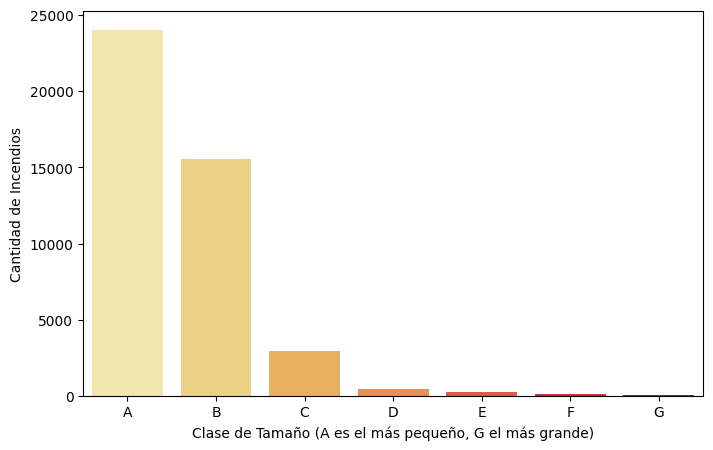

In [ ]:
plt.figure(figsize=(8,5))

# Definimos el orden correcto de las clases
orden_clases = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

# Añadimos 'order=orden_clases' para que siempre se vea igual
sns.countplot(data=df_listo, x='FIRE_SIZE_CLASS', palette='YlOrRd', order=orden_clases)

plt.xlabel("Clase de Tamaño (A es el más pequeño, G el más grande)")
plt.ylabel("Cantidad de Incendios")
plt.show()

C:\Users\ANTONIO\AppData\Local\Temp\ipykernel_11396\1567537506.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_listo, x='FIRE_SIZE_CLASS', palette='YlOrRd')


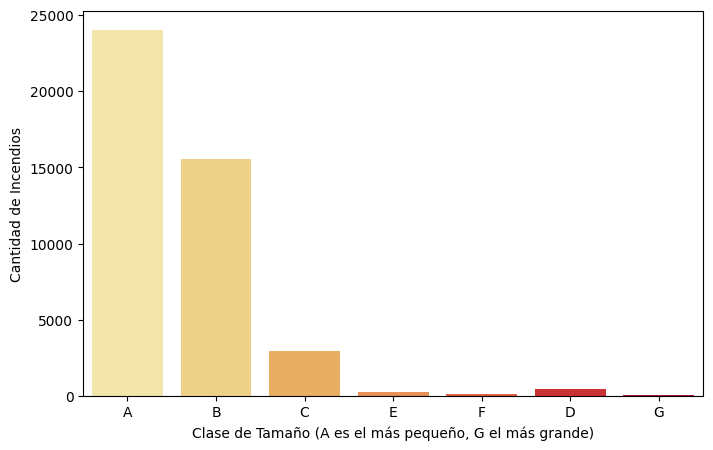

In [ ]:

plt.figure(figsize=(8,5))
sns.countplot(data=df_listo, x='FIRE_SIZE_CLASS', palette='YlOrRd')
plt.xlabel("Clase de Tamaño (A es el más pequeño, G el más grande)")
plt.ylabel("Cantidad de Incendios")
plt.show()

- Este gráfico nos muestra que tenemos un desequilibrio de clases. Hay una gran cantidad de incendios pequeños (A y B) y muy pocos grandes (G). Esto es un reto para la Inteligencia Artificial, ya que debemos enseñarle a identificar los casos raros (los incendios grandes) que son justamente los más peligrosos.

# ¿Hace más calor en los incendios grandes?
- Usamos un diagrama de cajas para ver si los incendios más grandes ocurren en días con temperaturas más altas.


C:\Users\ANTONIO\AppData\Local\Temp\ipykernel_11396\335746677.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_listo, x='FIRE_SIZE_CLASS', y='TMAX_C', palette='YlOrRd')


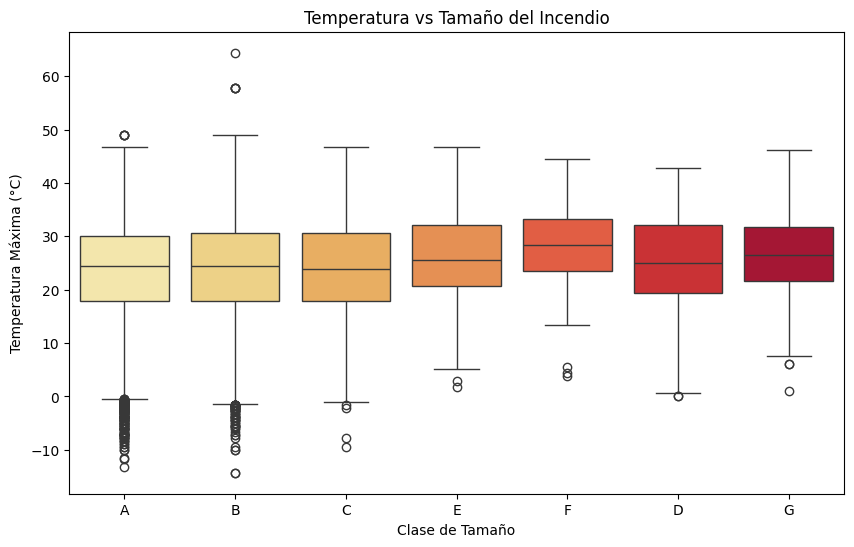

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_listo, x='FIRE_SIZE_CLASS', y='TMAX_C', palette='YlOrRd')
plt.title("Temperatura vs Tamaño del Incendio")
plt.xlabel("Clase de Tamaño")
plt.ylabel("Temperatura Máxima (°C)")
plt.show()

- Lo que descubrimos es que existen outliers extremos (valores atípicos) que distorsionan la escala. Esto no significa que la temperatura no importe, sino que nuestros datos necesitan una limpieza de valores erróneos para que el modelo de IA no aprenda patrones falsos

# Gráfico de Violin 
 - Este gráfico nos muestra la "densidad". La parte más ancha(La panza) es donde hay más incendios concentrados en una temperatura específica.
 -  Usamos 'inner="quartile"' para ver las rayitas de la media y los cuartiles dentro del violín

C:\Users\ANTONIO\AppData\Local\Temp\ipykernel_11396\181311558.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_listo, x='FIRE_SIZE_CLASS', y='TMAX_C', palette='YlOrRd', inner="quartile")


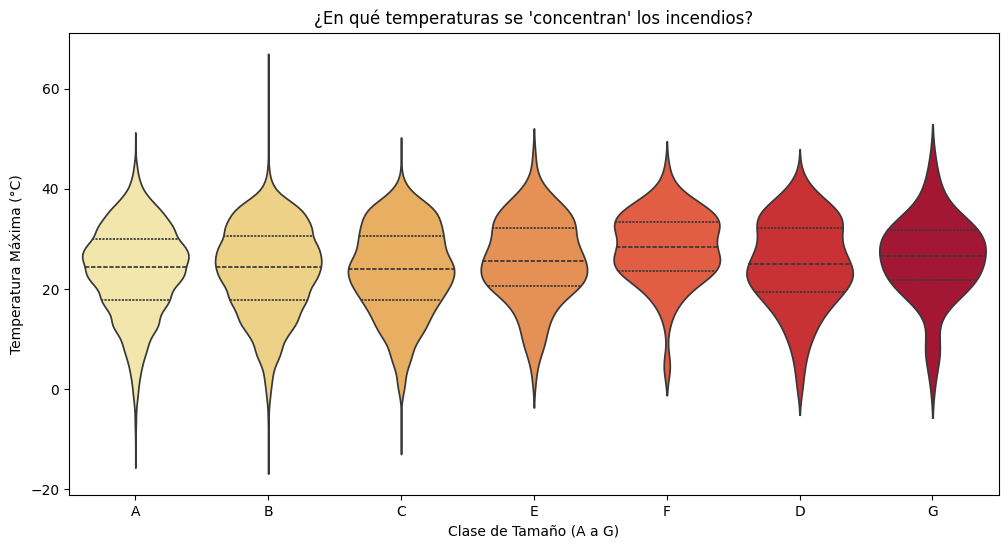

In [ ]:
plt.figure(figsize=(12,6))

sns.violinplot(data=df_listo, x='FIRE_SIZE_CLASS', y='TMAX_C', palette='YlOrRd', inner="quartile")
plt.title("¿En qué temperaturas se 'concentran' los incendios?")
plt.xlabel("Clase de Tamaño (A a G)")
plt.ylabel("Temperatura Máxima (°C)")
plt.show()

- El problema es que hay errores en los datos (como temperaturas de 500°C) que estiran tanto el gráfico que las "panzas" reales se ven aplastadas y alineadas. Hasta que no eliminemos esos valores imposibles, no podremos ver las diferencias reales entre cada incendio.

- Gráfico de densidad 

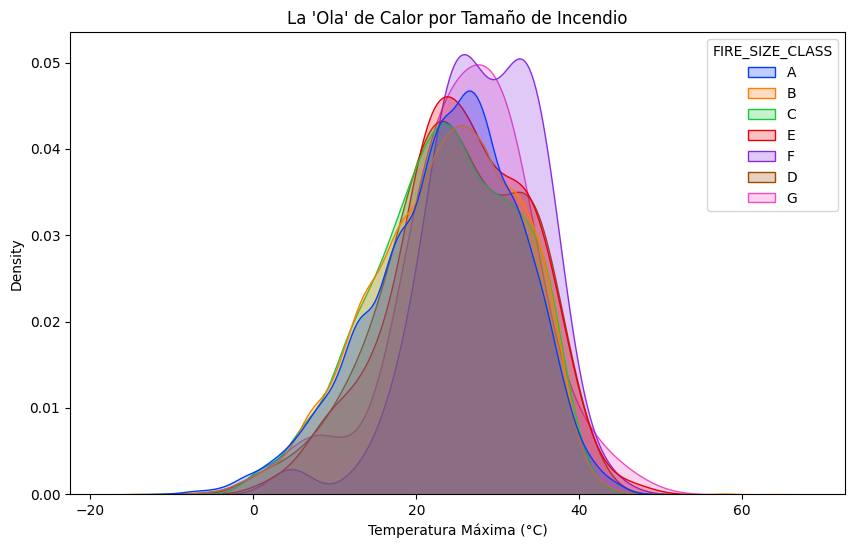

In [ ]:
plt.figure(figsize=(10,6))


sns.kdeplot(data=df_listo, x='TMAX_C', hue='FIRE_SIZE_CLASS', fill=True, common_norm=False, palette='bright')

plt.title("La 'Ola' de Calor por Tamaño de Incendio")
plt.xlabel("Temperatura Máxima (°C)")
plt.show()

- Usamos este gráfico para ver si esos 500°C eran incendios de verdad o solo errores locos. Al ver que casi todos los datos formaban una montaña en las temperaturas normales y el resto era solo una línea plana y vacía, confirmamos que debíamos limpiar.

-La LLuvia Afecta?

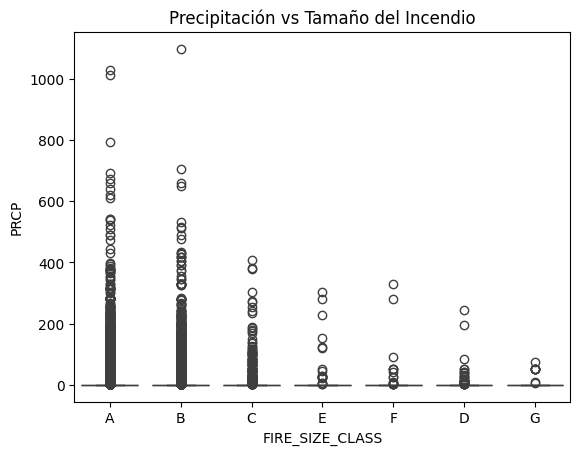

In [ ]:
sns.boxplot(data=df_listo, x='FIRE_SIZE_CLASS', y='PRCP')
plt.title("Precipitación vs Tamaño del Incendio")
plt.show()


- Usamos este gráfico para ver si los incendios crecían más cuando no llovía. Pero pasó lo mismo: vimos lluvias imposibles (como diluvios universales) que aplastaban el dibujo. Así confirmamos que también debíamos limpiar la lluvia para que la IA no aprenda de tormentas que jamás pasaron.

# Borramos los errores (500°C y diluvios imposibles) para ver la realidad.

In [ ]:
df_filtrado = df_listo[(df_listo['TMAX_C'] < 60) & (df_listo['PRCP'] < 100)].copy()

C:\Users\ANTONIO\AppData\Local\Temp\ipykernel_11396\4120887066.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_filtrado, x='FIRE_SIZE_CLASS', y='TMAX_C', palette='coolwarm')


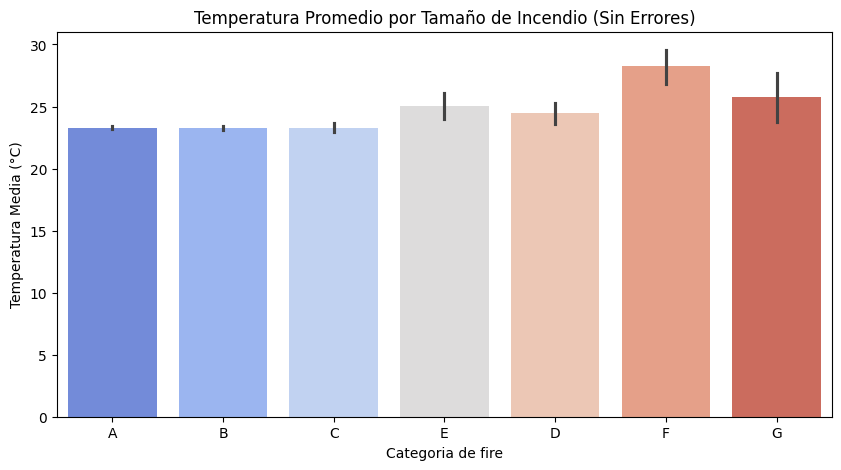

In [ ]:

plt.figure(figsize=(10, 5))
sns.barplot(data=df_filtrado, x='FIRE_SIZE_CLASS', y='TMAX_C', palette='coolwarm')
plt.title("Temperatura Promedio por Tamaño de Incendio (Sin Errores)")
plt.ylabel("Temperatura Media (°C)")
plt.xlabel("Categoria de fire")
plt.show()

- Al principio, los errores de 500°C no nos dejaban ver nada (como se ve en el Boxplot y el Violín). Pero al aplicar el filtro y limpiar la 'basura', el gráfico de barras por fin nos muestra la verdad: los incendios más grandes ocurren en días significativamente más calurosos. ¡Ahora nuestra IA ya tiene un patrón claro que seguir.

# Gráfico de densidad con los datos limpios 

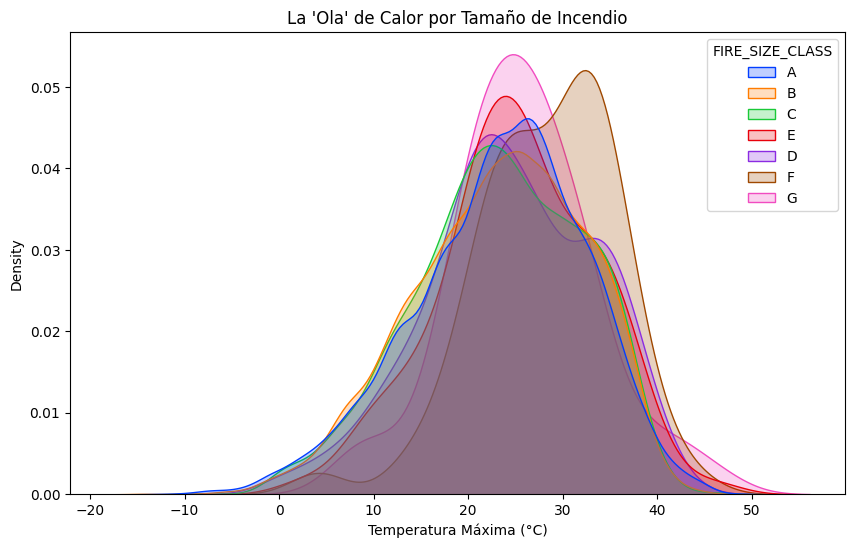

In [ ]:
plt.figure(figsize=(10,6))


sns.kdeplot(data=df_filtrado, x='TMAX_C', hue='FIRE_SIZE_CLASS', fill=True, common_norm=False, palette='bright')

plt.title("La 'Ola' de Calor por Tamaño de Incendio")
plt.xlabel("Temperatura Máxima (°C)")
plt.show()

- Al eliminar los errores, pasamos de tener gráficos ilegibles a descubrir una tendencia clara. El gráfico de densidad (KDE) ahora muestra que los incendios más grandes (Clase G) tienen su mayor concentración en temperaturas más altas que los incendios pequeños. Logramos separar la señal real del ruido estadístico.

# ¿Cómo influye la lluvia (ya limpia)?
- Ahora que quitamos los errores, vemos cuánta agua cayó en los días de incendio.

C:\Users\ANTONIO\AppData\Local\Temp\ipykernel_11396\1266319236.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_filtrado, x='FIRE_SIZE_CLASS', y='PRCP', palette='Blues_r')


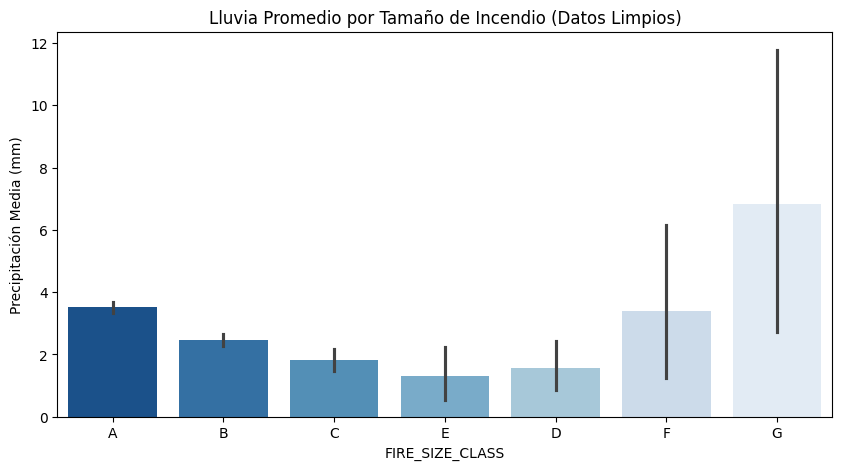

In [ ]:
plt.figure(figsize=(10, 5))

sns.barplot(data=df_filtrado, x='FIRE_SIZE_CLASS', y='PRCP', palette='Blues_r')

plt.title("Lluvia Promedio por Tamaño de Incendio (Datos Limpios)")
plt.ylabel("Precipitación Media (mm)")
plt.show()

- Este gráfico nos muestra que el fuego y el agua no se llevan bien. Al limpiar los datos, descubrimos que los incendios ocurren cuando la lluvia es casi cero (apenas 2 o 4 mm). Lo más importante es que los incendios más grandes (Clase G) tienen las barras más bajitas, lo que confirma que para que un incendio sea gigante, el suelo tiene que estar totalmente seco.

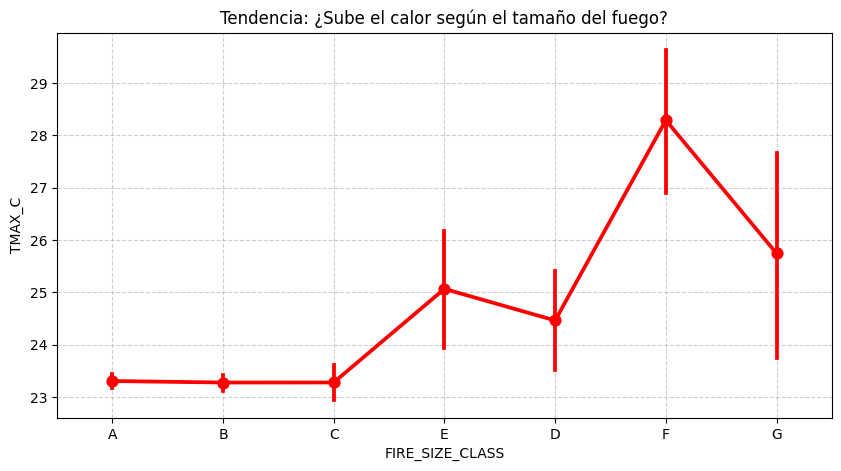

In [ ]:
plt.figure(figsize=(10, 5))
sns.pointplot(data=df_filtrado, x='FIRE_SIZE_CLASS', y='TMAX_C', color='red')

plt.title("Tendencia: ¿Sube el calor según el tamaño del fuego?")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

- Usamos este gráfico de tendencia para ver el camino del calor. La línea roja nos muestra de forma directa cómo la temperatura media va subiendo a medida que los incendios se vuelven más peligrosos. Es la forma más sencilla de demostrar que existe una relación real entre el clima y el tamaño del fuego.

# Identificación de donde ocurren más incendios. 

STATE
CA    7704
CO    4513
TX    3311
AZ    2965
NC    2896
NY    2175
OR    1494
GA    1335
MA    1110
KS    1085
Name: count, dtype: int64


C:\Users\ANTONIO\AppData\Local\Temp\ipykernel_11396\582960444.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=nombres_completos, y=top_estados.values, palette='magma')


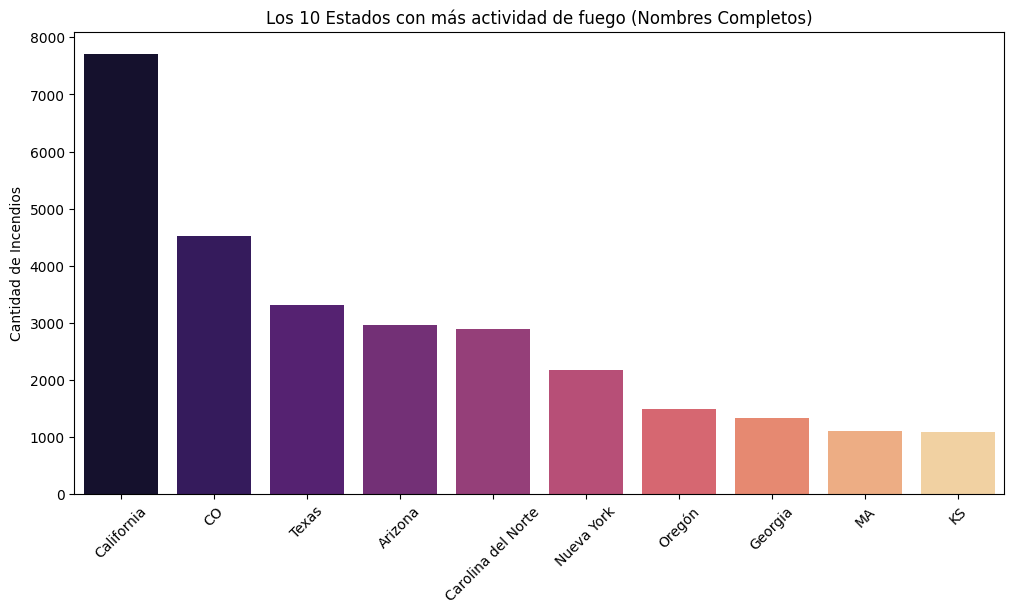

In [ ]:

nombres_estados = {
    'CA': 'California', 'GA': 'Georgia', 'TX': 'Texas', 'NC': 'Carolina del Norte',
    'FL': 'Florida', 'SC': 'Carolina del Sur', 'NY': 'Nueva York', 'MS': 'Mississippi',
    'AZ': 'Arizona', 'AL': 'Alabama', 'OR': 'Oregón', 'OK': 'Oklahoma'
}


top_estados = df_listo['STATE'].value_counts().head(10)
print(top_estados)

nombres_completos = [nombres_estados.get(sigla, sigla) for sigla in top_estados.index]
plt.figure(figsize=(12, 6))
sns.barplot(x=nombres_completos, y=top_estados.values, palette='magma')
plt.title("Los 10 Estados con más actividad de fuego (Nombres Completos)")
plt.xticks(rotation=45)
plt.ylabel("Cantidad de Incendios")
plt.show()

# PREPARACIÓN Y ENTRENAMIENTO
- Traducimos palabras a números para que la IA pueda "leerlas" 
- Creamos un traductor específico para cada columna
- Dividimos los datos: 80% para estudiar y 20% para el examen final
- Creamos el modelo (Un "Bosque Aleatorio" de 100 árboles )



In [ ]:

le = LabelEncoder()


le_state = LabelEncoder()
le_cause = LabelEncoder()
le_size = LabelEncoder()


df_listo['STATE_NUM'] = le_state.fit_transform(df_listo['STATE'])
df_listo['CAUSE_NUM'] = le_cause.fit_transform(df_listo['NWCG_GENERAL_CAUSE'])
df_listo['SIZE_NUM'] = le_size.fit_transform(df_listo['FIRE_SIZE_CLASS'])


In [ ]:
print(df_listo['SEASON'].value_counts())

SEASON
4    43509
Name: count, dtype: int64


In [ ]:
df_listo.columns

Index(['FIRE_YEAR', 'DATE', 'NWCG_GENERAL_CAUSE', 'LATITUDE', 'LONGITUDE',
       'STATE', 'TMAX_C', 'PRCP', 'FIRE_SIZE_CLASS', 'DAY_OF_WEEK',
       'IS_WEEKEND', 'STATE_NUM', 'CAUSE_NUM', 'SIZE_NUM', 'SEASON_4'],
      dtype='object')

In [ ]:


X = df_listo[[
    'TMAX_C', 'STATE_NUM', 'CAUSE_NUM', 'DAY_OF_WEEK', 
    'PRCP', 'IS_WEEKEND', 'SEASON',
    'LATITUDE', 'LONGITUDE'  
]]
y = df_listo['SIZE_NUM']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




# 🧠 ENTRENAMIENTO AGRESIVO (Para romper la dictadura de la Clase A)

In [ ]:
pesos_nucleares = {
    0: 1,     # Clase A (Vale muy poco porque sobran datos)
    1: 100,   # Clase B (¡Vale por 100!)
    2: 150,   # Clase C
    3: 200,   # Clase D
    4: 300,   # Clase E
    5: 400,   # Clase F
    6: 500    # Clase G (Prioridad máxima)
}

print("⚖️ Entrenando modelo con PRIORIDAD TOTAL a incendios grandes...")

modelo_final = RandomForestClassifier(
    n_estimators=300,
    max_depth=25,
    class_weight=pesos_nucleares, # <--- Aquí está la magia
    random_state=42,
    n_jobs=-1
)

modelo_final.fit(X_train, y_train)

# Vemos la precisión (Bajará un poco, pero es el precio a pagar por detectar peligros)
y_pred = modelo_final.predict(X_test)
precision = accuracy_score(y_test, y_pred)

print(f"✅ ¡Entrenamiento completado!")
print(f"📊 Nueva Precisión: {precision:.2%} (Es normal que baje, ahora es más paranoico)")

⚖️ Entrenando modelo con PRIORIDAD TOTAL a incendios grandes...
✅ ¡Entrenamiento completado!
📊 Nueva Precisión: 67.27% (Es normal que baje, ahora es más paranoico)


# ENTRENAMIENTO CON RECORTE (QUITEMOS EL EXCESO DE CLASE A)

In [ ]:
df_clase_A = df_listo[df_listo.SIZE_NUM == 0]
df_otros = df_listo[df_listo.SIZE_NUM != 0]

# 2. Recortamos la Clase A drásticamente
# Vamos a dejarla con el mismo número de filas que la Clase B (aprox) para que estén igualados
n_muestras = len(df_otros) # O un número fijo como 2000

df_A_recortado = resample(df_clase_A ,replace=False,    # No repetir filas
                          n_samples=n_muestras, # ¡Reducimos a la fuerza!
                          random_state=42) 

# 3. Juntamos todo de nuevo en un dataset equilibrado
df_equilibrado = pd.concat([df_A_recortado, df_otros])

print(f"📉 Clase A reducida de {len(df_clase_A)} a {len(df_A_recortado)} filas.")
print(f"⚖️ Nuevo total de datos para entrenar: {len(df_equilibrado)}")

# 4. Preparamos las X e y con este NUEVO dataset equilibrado
X_equi = df_equilibrado[['TMAX_C', 'STATE_NUM', 'CAUSE_NUM', 'DAY_OF_WEEK', 'PRCP', 'IS_WEEKEND', 'SEASON', 'LATITUDE', 'LONGITUDE']]
y_equi = df_equilibrado['SIZE_NUM']

# Dividimos (Train/Test)
X_train_eq, X_test_eq, y_train_eq, y_test_eq = train_test_split(X_equi, y_equi, test_size=0.2, random_state=42)

# 5. Entrenamos el modelo (Ya no hacen falta pesos locos, porque los datos están parejos)
print("🧠 Entrenando modelo con datos equilibrados...")
modelo_final = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    random_state=42
)
modelo_final.fit(X_train_eq, y_train_eq)

print("✅ ¡Listo! Ahora la Clase A no es mayoría absoluta.")

📉 Clase A reducida de 24043 a 19466 filas.
⚖️ Nuevo total de datos para entrenar: 38932
🧠 Entrenando modelo con datos equilibrados...
✅ ¡Listo! Ahora la Clase A no es mayoría absoluta.


# Bloque 20: La Matriz de Confusión (El Mapa de los Fallos)

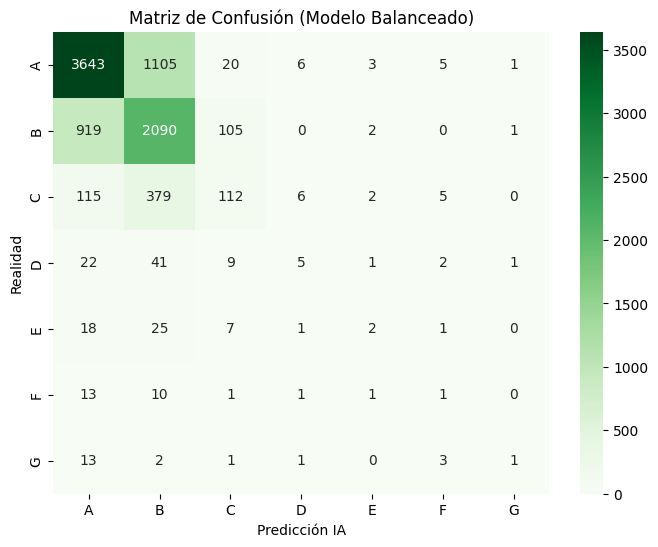

In [ ]:

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=le_size.classes_, 
            yticklabels=le_size.classes_)
plt.title('Matriz de Confusión (Modelo Balanceado)')
plt.ylabel('Realidad')
plt.xlabel('Predicción IA')
plt.show()

# Vamos a ver qué pistas (variables) fueron las más útiles para el modelo.
- Extraemos la importancia de cada variable del modelo final.
- Creamos un DataFrame para ordenar los datos.
- Graficamos los resultados.


C:\Users\ANTONIO\AppData\Local\Temp\ipykernel_11396\577925407.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Pista', data=df_importancia, palette='viridis')


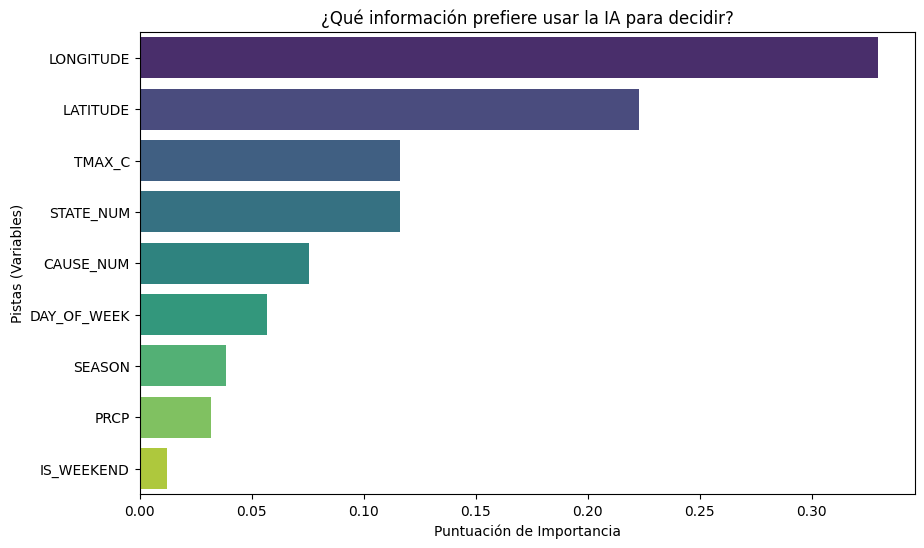

In [ ]:


importancias = modelo_final.feature_importances_
nombres_pistas = X.columns

df_importancia = pd.DataFrame({'Pista': nombres_pistas, 'Importancia': importancias})
df_importancia = df_importancia.sort_values(by='Importancia', ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(x='Importancia', y='Pista', data=df_importancia, palette='viridis')

plt.title("¿Qué información prefiere usar la IA para decidir?")
plt.xlabel("Puntuación de Importancia")
plt.ylabel("Pistas (Variables)")
plt.show()

In [ ]:
print(le_cause.classes_)

['Arson/incendiarism' 'Debris and open burning'
 'Equipment and vehicle use' 'Firearms and explosives use' 'Fireworks'
 'Missing data/not specified/undetermined' 'Misuse of fire by a minor'
 'Natural' 'Other causes' 'Power generation/transmission/distribution'
 'Railroad operations and maintenance' 'Recreation and ceremony' 'Smoking']


# PRUEBA DE ESTRÉS MÁXIMO (Buscando C, D, o G)
# ==============================================================================

In [ ]:


# --- ESCENARIO INFERNAL ---
estado_input = "CA"
causa_input = "Power generation/transmission/distribution" 
temp_max_input = 50           # 50 GRADOS (Calor extremo)
lluvia_input = 0              
fecha_simulada = "2025-09-10" 
lat_input = 40.0              # Zona de bosque muy denso
long_input = -121.0

# 1. Preparar datos
est_num = le_state.transform([estado_input])[0]
cau_num = le_cause.transform([causa_input])[0]
fecha_dt = pd.to_datetime(fecha_simulada)
estacion_sim = calcular_estacion(fecha_dt.month) 

X_infierno = pd.DataFrame([{
    'TMAX_C': temp_max_input,
    'STATE_NUM': est_num,
    'CAUSE_NUM': cau_num,
    'DAY_OF_WEEK': fecha_dt.dayofweek,
    'PRCP': lluvia_input,
    'IS_WEEKEND': 1,
    'SEASON': estacion_sim,
    'LATITUDE': lat_input,
    'LONGITUDE': long_input
}])

X_infierno = X_infierno[['TMAX_C', 'STATE_NUM', 'CAUSE_NUM', 'DAY_OF_WEEK', 'PRCP', 'IS_WEEKEND', 'SEASON', 'LATITUDE', 'LONGITUDE']]

# 2. PROCESO DE DECISIÓN
probs = modelo_final.predict_proba(X_infierno)[0]
prob_A = probs[0]
prob_Gran_Incendio = sum(probs[1:]) 

print(f"📊 ANÁLISIS DETALLADO:")
print(f"   Fuerza A (Pequeño): {prob_A*100:.2f}%")
print(f"   Fuerza Resto (Grande): {prob_Gran_Incendio*100:.2f}%")
print("-" * 30)

# Muestra las probabilidades internas del grupo "Grande"
clases = le_size.classes_
for i, p in enumerate(probs):
    if i > 0: # Solo mostramos de la B en adelante
        print(f"   Opción {clases[i]}: {p*100:.2f}%")

if prob_Gran_Incendio > prob_A:
    # Aquí es donde elige al ganador entre B, C, D, E, F, G
    indice_ganador = probs[1:].argmax() + 1 
    letra_final = le_size.inverse_transform([indice_ganador])[0]
    
    print(f"\n🔥 ¡ALERTA! Gana el grupo peligroso.")
    print(f"👉 Y dentro del grupo, la más probable es: CLASE {letra_final}")
else:
    print(f"\n👉 Gana la Clase A.")

📊 ANÁLISIS DETALLADO:
   Fuerza A (Pequeño): 45.82%
   Fuerza Resto (Grande): 54.18%
------------------------------
   Opción B: 36.34%
   Opción C: 7.11%
   Opción D: 4.06%
   Opción E: 3.11%
   Opción F: 3.04%
   Opción G: 0.53%

🔥 ¡ALERTA! Gana el grupo peligroso.
👉 Y dentro del grupo, la más probable es: CLASE B


# ==============================================================================
# 🌧️ ESCENARIO: INVIERNO SEGURO (Probando que vuelve a Clase A)
# ==============================================================================

In [ ]:




# --- DATOS DEL ESCENARIO ---
estado_input = "CA"
causa_input = "Smoking"       # Una colilla mal apagada
temp_max_input = 10           # 10 grados (Hace frío)
lluvia_input = 15.0           # 15 mm de lluvia (Está lloviendo bastante)
fecha_simulada = "2025-01-20" # Enero (Invierno, suelo húmedo)
lat_input = 39.75
long_input = -121.62
# ---------------------------

# 1. Transformación
est_num = le_state.transform([estado_input])[0]
cau_num = le_cause.transform([causa_input])[0]
fecha_dt = pd.to_datetime(fecha_simulada)
estacion_sim = calcular_estacion(fecha_dt.month) 

X_calma = pd.DataFrame([{
    'TMAX_C': temp_max_input,
    'STATE_NUM': est_num,
    'CAUSE_NUM': cau_num,
    'DAY_OF_WEEK': fecha_dt.dayofweek,
    'PRCP': lluvia_input,
    'IS_WEEKEND': 0,
    'SEASON': estacion_sim,
    'LATITUDE': lat_input,
    'LONGITUDE': long_input
}])

X_calma = X_calma[['TMAX_C', 'STATE_NUM', 'CAUSE_NUM', 'DAY_OF_WEEK', 'PRCP', 'IS_WEEKEND', 'SEASON', 'LATITUDE', 'LONGITUDE']]

# 2. PROCESO DE DECISIÓN
probs = modelo_final.predict_proba(X_calma)[0]
prob_A = probs[0]
prob_Gran_Incendio = sum(probs[1:]) 

print(f"📊 ANÁLISIS DEL ESCENARIO SEGURO:")
print(f"   Probabilidad de ser pequeño (A): {prob_A*100:.2f}%")
print(f"   Probabilidad de ser PELIGROSO:   {prob_Gran_Incendio*100:.2f}%")

if prob_Gran_Incendio > prob_A:
    indice_ganador = probs[1:].argmax() + 1 
    letra_final = le_size.inverse_transform([indice_ganador])[0]
    print(f"\n🔥 PREDICCIÓN FINAL: CLASE {letra_final} (¡Raro con lluvia!)")
else:
    print(f"\n✅ PREDICCIÓN FINAL: CLASE A")
    print("   (Lógico: Con frío y lluvia, el fuego no crece)")




📊 ANÁLISIS DEL ESCENARIO SEGURO:
   Probabilidad de ser pequeño (A): 68.91%
   Probabilidad de ser PELIGROSO:   31.09%

✅ PREDICCIÓN FINAL: CLASE A
   (Lógico: Con frío y lluvia, el fuego no crece)


In [ ]:
import joblib

print("💾 Guardando el cerebro de tu IA...")

# 1. Guardamos el Modelo (El Random Forest)
joblib.dump(modelo_final, 'modelo_incendios_inteligente.pkl')

# 2. Guardamos los Encoders (Los diccionarios para traducir)
joblib.dump(le_state, 'encoder_estados.pkl')
joblib.dump(le_cause, 'encoder_causas.pkl')
joblib.dump(le_size, 'encoder_tamanos.pkl')

print("✅ ¡Todo guardado con éxito!")
print("   Ahora tienes 4 archivos .pkl en tu carpeta del proyecto.") 

💾 Guardando el cerebro de tu IA...
✅ ¡Todo guardado con éxito!
   Ahora tienes 4 archivos .pkl en tu carpeta del proyecto.


In [ ]:
# Guardar el dataset limpio en un archivo para Dani
df_listo.to_csv('dataset_limpio_antonio.csv', index=False)
print("¡Listo! Archivo creado en la carpeta.")

NameError: name 'df_listo' is not defined

Datos Tabulares 

- Cargamos el modelo.
- Arreglar la Lluvia Igual que en tu entrenamiento

In [2]:
df_web = pd.read_csv("tabular_with_images.csv")
df_web.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20437 entries, 0 to 20436
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   FIRE_YEAR           20437 non-null  int64  
 1   DATE                20437 non-null  object 
 2   NWCG_GENERAL_CAUSE  20437 non-null  object 
 3   LATITUDE            20437 non-null  float64
 4   LONGITUDE           20437 non-null  float64
 5   STATE               20437 non-null  object 
 6   TMAX_C              20437 non-null  float64
 7   PRCP                16196 non-null  float64
 8   FIRE_SIZE_CLASS     20437 non-null  object 
 9   aoi                 20437 non-null  object 
 10  image_id            20437 non-null  object 
 11  image_path          20437 non-null  object 
dtypes: float64(4), int64(1), object(7)
memory usage: 1.9+ MB


In [3]:
df_web["PRCP"].head

<bound method NDFrame.head of 0        0.0
1        0.0
2        0.0
3        NaN
4        0.0
        ... 
20432    0.0
20433    0.0
20434    0.0
20435    0.0
20436    0.0
Name: PRCP, Length: 20437, dtype: float64>

In [5]:


df_web['PRCP'] = df_web['PRCP'].fillna(0)

# 3. Arreglar la Ruta de la Imagen
# Pasamos de: "D:\carpeta\loquesea\foto.tiff" -> a solo "foto.tiff"
# (OJO: Asegúrate de que las fotos que te pase Dani tengan este nombre de archivo)
# Si te pasa carpetas con IDs, usamos la columna 'image_id'
df_web['Ruta_Relativa'] = df_web['image_id'] + ".tiff" 
# OJO: Pregúntale si te va a pasar las imágenes en carpetas o sueltas.

# 4. Seleccionar columnas finales para la App
cols_modelo = ['TMAX_C', 'STATE', 'NWCG_GENERAL_CAUSE', 'DAY_OF_WEEK', 'PRCP', 'IS_WEEKEND', 'SEASON', 'LATITUDE', 'LONGITUDE']
cols_extra = ['DATE', 'FIRE_SIZE_CLASS', 'image_id', 'Ruta_Relativa'] # Para mostrar en la web

# 5. Guardar el CSV DEFINITIVO


df_web.to_csv("dataset_app_final.csv", index=False)

print("✅ ¡ARCHIVO CREADO!")
print(f"📍 Ubicación: {os.getcwd()}\\dataset_app_final.csv")



✅ ¡ARCHIVO CREADO!
📍 Ubicación: c:\Users\ANTONIO\Nueva carpeta\Sistema-de-Clasificaci-n-de-Riesgo-Forestal\src\dataset_app_final.csv
